In [1]:
  # Import libraries
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import scikitplot as skplt

from plotly.offline import iplot

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from tensorflow import keras
from tensorflow.keras import initializers, layers

## Load dataset relating items and skills

In [2]:
datas = list()
originals = list()
masks = list()

for i in range(100):
    data = pd.read_csv('output_data/50_missing/y/Y_rep' + str(i+1) + '_transformer_50_missing.csv', sep=';', header=None)
    data_train = np.ones(data.shape)
    data_train[data < 0.5] = 0.
    datas.append(data_train)
    original = pd.read_csv('input_data/y/Yrep' + str(i+1) + '.csv', sep=';', header=None)
    originals.append(original.values.reshape((90, 10000)).transpose()[:8000, :])
    masks.append(pd.read_csv('output_data/50_missing/masked/Masked_rep' + str(i+1) + '_50_missing.csv', sep=';', header=None))


In [3]:
Q = pd.read_csv('input_data/qmatrix/Qmatrix.csv', sep=';', header=None)
Q = Q.T
print(Q.shape)

(21, 90)


In [4]:
for d, m, o in zip(datas, masks, originals):

    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if m.iloc[i, j] != -1 and d[i, j] != o[i, j]:
                d[i, j] = o[i, j]

In [5]:
print(datas)

[array([[1., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]]), array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 1., 0., 1.],
       [1., 0., 1., ..., 0., 0., 0.]]), array([[1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [0., 1., 1., ..., 0., 0., 0.]]), array([[1., 0., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]]), array([[1., 1., 1., ..., 0., 0.

In [6]:
# Set stats and skills
num_stats = datas[0].shape[1] 
num_skills = 21

intermediate_dim=40

# Number of subjects
N = datas[0].shape[0]
# Training number
tr = N
batch_size = 50
epochs = 100

In [7]:
""" Helper functions """

# Restrict connection in decoder
def q_constraint(w):
    target = w * Q
    diff = w - target
    w = w * tf.cast(tf.math.equal(diff, 0), keras.backend.floatx()) 
    return w * tf.cast(tf.math.greater_equal(w, 0), keras.backend.floatx())

# Remove zeros function
def remove_zeros(arr):
  n_arr = []
  
  for j in range(num_skills): 
    for i in range(num_stats):
      if Q.iloc[j, i] != 0:
        n_arr.append(arr[j][i])
  
  return n_arr


In [8]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
  
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(keras.Model):
    """Maps items respone to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=num_skills, intermediate_dim=intermediate_dim, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="tanh")
        self.dense_mean = layers.Dense(latent_dim
                                       #, kernel_initializer=initializers.Zeros()
                                       )
        self.dense_log_var = layers.Dense(latent_dim
                                          #, kernel_initializer=initializers.Zeros()
                                          )
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        #tf.print(tf.math.reduce_mean(z_mean))
        z_log_var = self.dense_log_var(x)
        #tf.print(tf.math.reduce_mean(tf.math.exp(0.5 * z_log_var)))

        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(keras.Model):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, latent_dim=num_skills, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        #self.dense_proj = layers.Dense(latent_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim
                                         , activation="sigmoid"
                                         , kernel_constraint=q_constraint
                                         #, kernel_initializer=initializers.Ones()
                                         #, bias_initializer=initializers.Zeros()
                                         )

    def call(self, inputs):
        #x = self.dense_proj(inputs)
        return self.dense_output(inputs)



class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=intermediate_dim,
        latent_dim=num_skills,
        name="autoencoder"
    ):
        super(VariationalAutoEncoder, self).__init__(name=name)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, latent_dim=latent_dim)

    def call(self, inputs):
        self.z_mean, self.z_log_var, self.z = self.encoder(inputs)
        reconstructed = self.decoder(self.z)
        return reconstructed

    # Loss function
    def vae_loss(self, input, output):
        cross_entropy_loss = (num_stats / 1.0) * keras.losses.binary_crossentropy(input, output)
        kl_loss = -0.5 * tf.reduce_mean(self.z_log_var - tf.square(self.z_mean) - tf.exp(self.z_log_var) + 1, axis=-1)
        return cross_entropy_loss + kl_loss

    # Get weights
    def _get_weights(self):
        return self.decoder.trainable_weights

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

In [9]:
thetas = pd.DataFrame()
thetas_logvar = pd.DataFrame()
discrs_hat = pd.DataFrame()
diffs = pd.DataFrame()
preds = pd.DataFrame()

for i in range(100):
    
    vae_q = VariationalAutoEncoder(num_stats, intermediate_dim, num_skills)

    # Optimizer
    #opt = tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True)
    opt = tf.keras.optimizers.SGD(learning_rate=0.005)
    
    vae_q.compile(optimizer=opt, loss=vae_q.vae_loss, metrics=['binary_accuracy'])

    data_train = datas[i]
    
    history = vae_q.fit(data_train,
                        data_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        shuffle=True)
    # validation_split=0.2
    ba = 0
    for value in history.history['binary_accuracy']:
        ba += value
    print("Binary Accuracy: %.4f" % (ba / epochs))

    encoder = vae_q.get_encoder()
    decoder = vae_q.get_decoder()
    #weights = vae_q.get_decoder().trainable_weights

    weights = vae_q._get_weights()

    discr = weights[0].numpy()
    #print(discr.shape)
    #diff = pd.DataFrame(weights[3].numpy())
    negative_diff = pd.DataFrame(np.negative(weights[1].numpy()))

    # Get latent trait predictions
    thetas_hat, log_var_thetas_hat, z_pred = encoder.predict(data_train)
    pred = decoder.predict_step(z_pred)
    #print(pred)
    #print(thetas_hat)

    # Total score on the test -------
    score = np.apply_over_axes(np.sum, data_train, 1)

    #### Vectoring the matrices Thetas_hat ans discr ####
    theta_hat = np.transpose(thetas_hat).flatten()
    #step_theta_hat = np.transpose(step_thetas_hat.numpy()).flatten()
  
    log_var_theta_hat = np.transpose(log_var_thetas_hat).flatten()
    #step_log_var_theta_hat = np.transpose(step_log_var_thetas_hat.numpy()).flatten()

    discr_hat = remove_zeros(discr)

    # Save results
    theta_est_rep_GUI = pd.DataFrame({'Thetas Estimation': theta_hat, 'Log Var Thetas Estimation': log_var_theta_hat})
    theta_est_rep_GUI.to_csv('output_data/50_missing/theta/thetas_rep' + str(i+1) + '_transformer_50_missing.csv', sep=';', index=False)
    thetas['Rep' + str(i+1)] = theta_hat
    thetas_logvar['Rep' + str(i+1)] = log_var_theta_hat

    discr = pd.DataFrame(discr)
    discr.to_csv('output_data/50_missing/a/discr_rep' + str(i+1) + '_transformer_50_missing.csv', sep=';', header=None, index=False)

    discr_hat_GUI = pd.DataFrame([discr_hat])
    discr_hat_GUI.to_csv('output_data/50_missing/a/discr_hat_rep' + str(i+1) + '_transformer_50_missing.csv', sep=';', header=None, index=False)
    discrs_hat['Rep' + str(i+1)] = discr_hat

    # Save a estimated replication TRANSPOSED
    discr_hat_GUI.T.to_csv(
        'output_data/50_missing/a/discr_hat_rep' + str(i+1) + '_transformer_50_missing_TRANSPOSED.csv', sep=';', header=None, index=False)

    negative_diff.to_csv('output_data/50_missing/b/diff_rep' + str(i+1) + '_transformer_50_missing.csv', sep=';', header=None, index=False)
    diffs['Rep' + str(i+1)] = np.negative(weights[1].numpy())

    preds['Rep' + str(i+1)] = pred.numpy().flatten()


Epoch 1/100


2023-07-21 12:44:08.023929: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


160/160 [==============================] - 1s 675us/step - loss: 61.3781 - binary_accuracy: 0.6180
Epoch 2/100
160/160 [==============================] - 0s 528us/step - loss: 58.6511 - binary_accuracy: 0.6648
Epoch 3/100
160/160 [==============================] - 0s 557us/step - loss: 55.5204 - binary_accuracy: 0.6869
Epoch 4/100
160/160 [==============================] - 0s 527us/step - loss: 53.7525 - binary_accuracy: 0.6927
Epoch 5/100
160/160 [==============================] - 0s 518us/step - loss: 52.7345 - binary_accuracy: 0.6998
Epoch 6/100
160/160 [==============================] - 0s 527us/step - loss: 51.6969 - binary_accuracy: 0.7093
Epoch 7/100
160/160 [==============================] - 0s 527us/step - loss: 50.5609 - binary_accuracy: 0.7197
Epoch 8/100
160/160 [==============================] - 0s 525us/step - loss: 49.3448 - binary_accuracy: 0.7293
Epoch 9/100
160/160 [==============================] - 0s 510us/step - loss: 48.1395 - binary_accuracy: 0.7397
Epoch 10/100


In [10]:
binary_preds = np.ones(preds.shape)
binary_preds[preds.values < 0.5] = 0.

In [11]:
binary_preds = pd.DataFrame(binary_preds, columns=preds.columns)

In [12]:
# a artificial
a_values = pd.read_csv('input_data/a/a_values.csv', sep=';', header=None)
#a_rep_gui = pd.read_csv('output/discr_hat_transformer_10_missing_TRANSPOSED.csv', sep=';', header=0)

# b artificial
b_values = pd.read_csv('input_data/b/b_values.csv', sep=';', header=None)
#b_rep_gui = pd.read_csv('output/diff_transformer_10_missing.csv', sep=';', header=0)

# theta artificial
theta_values = pd.read_csv('input_data/theta/theta_values.csv', sep=';', header=None)
#theta_rep_gui = pd.read_csv('output/thetas_transformer_10_missing.csv', sep=';', header=0)

## Discriminations

In [13]:
cols = ['a_values']

a_results = pd.DataFrame(columns=cols)

a_results['a_values'] = a_values

a_results = pd.concat([a_results, discrs_hat], axis=1)

In [14]:
a_results['Bias'] = np.sum(a_values.values - discrs_hat.values, axis=1)/100
a_results['RMSE'] = np.sqrt(np.sum((a_values.values - discrs_hat)**2, axis=1)/100)
a_results['Abs Bias'] = np.sum(np.abs(a_values.values - discrs_hat.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/1112998409.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/1112998409.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/1112998409.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [15]:
corrs = []

for column in discrs_hat:
    corrs.append(a_results['a_values'].corr(discrs_hat['Rep1']))

a_results['Corr'] = ""
a_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/741033095.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/741033095.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
a_results

,a_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,1.232813,1.144732,1.096262,1.101917,1.067532,1.136027,1.101787,1.085193,1.105864,1.117682,...,1.067129,1.112023,1.063448,1.044985,1.146818,1.084600,0.132937,0.137721,0.132937,0.477592
1,1.134104,1.014091,0.951789,0.993608,1.018785,1.030488,1.003556,0.942607,0.938121,0.955251,...,0.940149,0.969741,0.961304,0.973432,0.937019,0.981436,0.161649,0.165541,0.161649,
2,1.738586,1.418776,1.346260,1.297366,1.421564,1.356436,1.357878,1.396685,1.378815,1.422850,...,1.360703,1.418127,1.382789,1.349029,1.401760,1.513540,0.347368,0.352242,0.347368,
3,2.110506,1.565827,1.502406,1.579383,1.544580,1.530197,1.529377,1.483001,1.523499,1.523756,...,1.538688,1.513857,1.533780,1.538810,1.493080,1.619527,0.584811,0.586807,0.584811,
4,0.770227,0.612047,0.640786,0.600242,0.584273,0.647620,0.689936,0.625855,0.622710,0.612862,...,0.595129,0.636445,0.573689,0.608986,0.577255,0.609689,0.154702,0.157466,0.154702,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2.280600,3.227271,3.191396,3.400697,3.375736,3.297675,3.346063,3.364228,3.413937,3.186141,...,3.395307,2.803101,3.305927,3.168965,3.360646,3.378898,-0.960292,0.987385,0.969513,
146,0.711949,0.671461,0.724205,0.625730,0.745486,0.496918,0.950066,0.876523,0.712184,0.806751,...,0.722948,0.666888,0.621444,0.739481,0.772746,0.836030,-0.009838,0.115622,0.087548,
147,0.912646,0.987088,0.882022,0.716616,0.800261,1.046866,0.805173,0.683772,0.648538,0.648349,...,0.695162,0.564974,0.841708,0.857033,0.633256,0.840830,0.135226,0.198246,0.166697,
148,1.041631,1.000525,0.867203,1.103639,0.665806,1.119007,0.782324,0.648988,0.786031,1.018790,...,0.720796,0.443971,1.152177,0.884722,0.835599,0.932470,0.143322,0.268798,0.209095,


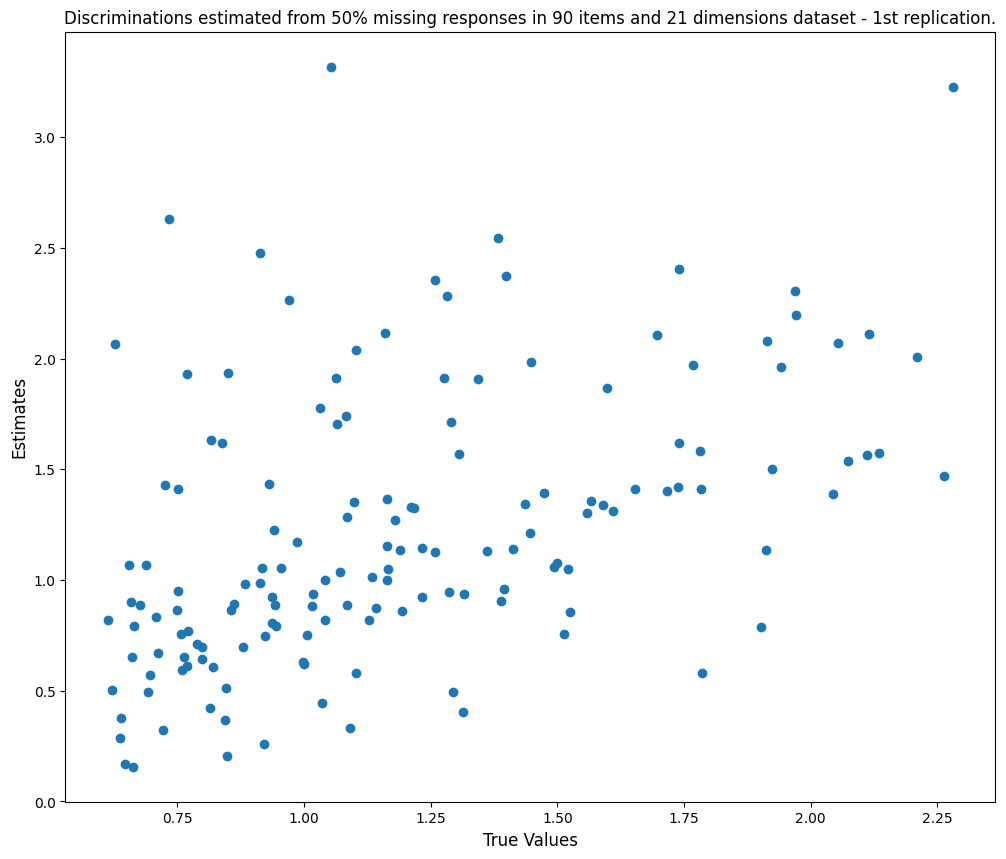

In [17]:
plt.figure(figsize=(12, 10))
plt.scatter(x=a_values, y=a_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Discriminations estimated from 50% missing responses in 90 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [18]:
a_results.to_csv('output_data/50_missing/a/a_results.csv', sep=';', header=True, index=False)

## Difficulties

In [19]:
cols = ['b_values']

b_results = pd.DataFrame(columns=cols)

b_results['b_values'] = b_values

b_results = pd.concat([b_results, diffs], axis=1)

In [20]:
b_results['Bias'] = np.sum(b_values.values - diffs.values, axis=1)/100
b_results['RMSE'] = np.sqrt(np.sum((b_values.values - diffs)**2, axis=1)/100)
b_results['Abs Bias'] = np.sum(np.abs(b_values.values - diffs.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/3793169349.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/3793169349.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/3793169349.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [21]:
corrs = []

for column in diffs:
    corrs.append(b_results['b_values'].corr(diffs[column]))

b_results['Corr'] = ""
b_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/713609593.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/713609593.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
b_results

,b_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,-1.194972,-1.748716,-1.762679,-1.852604,-1.624950,-1.784788,-1.793564,-1.673292,-1.799803,-1.728529,...,-1.702791,-1.736396,-1.587716,-1.687790,-1.778080,-1.704620,0.543014,0.547682,0.543014,0.960925
1,1.404483,2.311233,2.219872,2.228271,2.288392,2.306935,2.248619,2.248844,2.079440,2.249087,...,2.176430,2.236050,2.265609,2.296069,2.211552,2.225540,-0.822901,0.824992,0.822901,
2,-1.196988,-1.976416,-1.892062,-2.361742,-1.850710,-2.307086,-2.483341,-1.998513,-1.842113,-2.034962,...,-1.882355,-1.814570,-1.910312,-1.877397,-2.309144,-2.115564,0.857194,0.887057,0.857194,
3,0.472191,1.339797,1.243762,1.599002,1.196238,1.437180,1.901618,0.955134,1.320518,1.072891,...,0.847355,1.142345,1.233459,0.956703,1.325584,1.353392,-0.807994,0.843633,0.807994,
4,1.783818,1.854607,2.026062,2.040203,1.925392,1.801862,1.925821,1.878266,2.078983,1.823719,...,1.982004,1.916868,1.976298,2.084932,1.805141,1.922646,-0.153526,0.186053,0.157198,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.527809,0.894087,0.849228,0.640179,0.614659,0.814814,0.697751,0.776612,0.717878,0.782723,...,0.809165,0.827503,0.739514,0.751768,0.734491,0.808085,-0.253135,0.261743,0.253135,
86,-0.749307,-1.246645,-1.198066,-1.251221,-1.510470,-1.150560,-1.495944,-1.185330,-1.232183,-1.311256,...,-1.206093,-1.154716,-1.174428,-1.225411,-1.242053,-1.083541,0.491538,0.502288,0.491538,
87,0.163070,0.842512,0.735631,0.650589,0.585414,0.739511,0.702438,0.648538,0.702349,0.603995,...,0.761209,0.702795,0.672371,0.657947,0.649648,0.744556,-0.508286,0.516676,0.508286,
88,0.928725,1.635773,1.425852,1.480850,1.286079,1.555626,1.517170,1.347978,1.437581,1.486520,...,1.360570,1.374603,1.495335,1.474336,1.308071,1.488489,-0.519108,0.532402,0.519108,


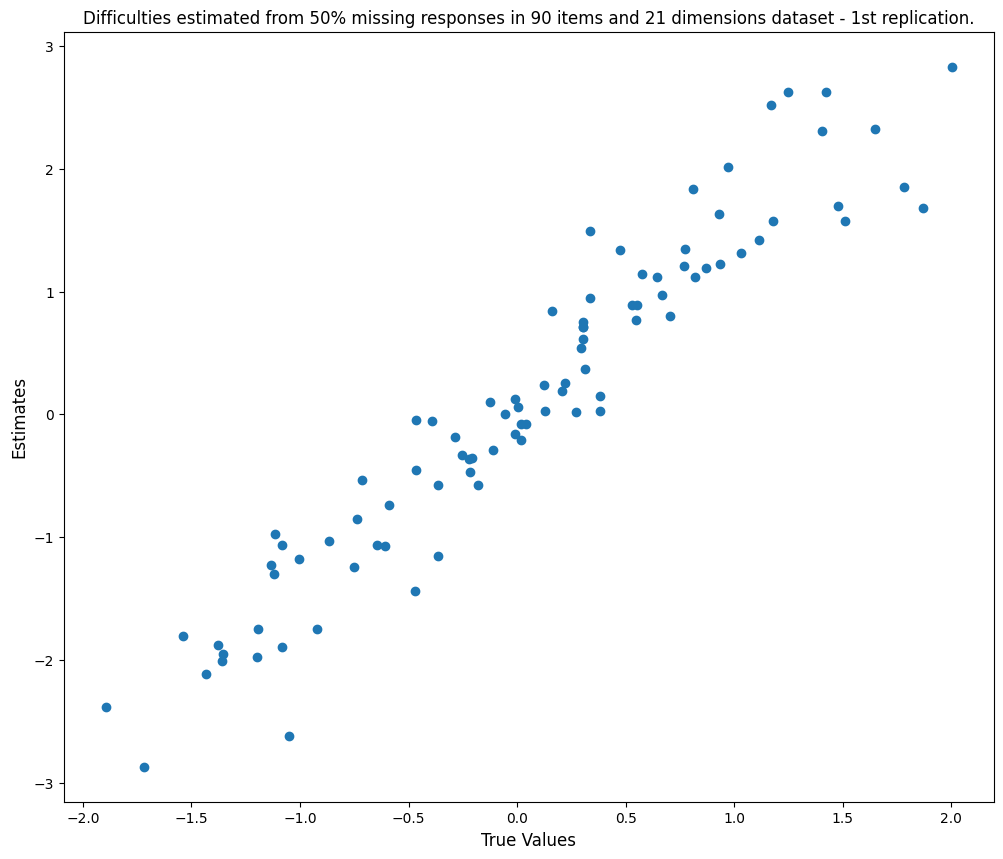

In [23]:
plt.figure(figsize=(12, 10))
plt.scatter(x=b_values, y=b_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Difficulties estimated from 50% missing responses in 90 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [24]:
b_results.to_csv('output_data/50_missing/b/b_results.csv', sep=';', header=True, index=False)

## Thetas

In [25]:
theta_values = theta_values.values.reshape((21, 10000))[:, :8000].flatten()

In [26]:
cols = ['theta_values']

theta_results = pd.DataFrame(columns=cols)

theta_results['theta_values'] = theta_values

theta_results = pd.concat([theta_results, thetas], axis=1)


In [27]:
theta_values = theta_values.reshape((theta_values.shape[0], 1))

In [28]:
theta_results['Bias'] = np.sum(theta_values - thetas.values, axis=1)/100
theta_results['RMSE'] = np.sqrt(np.sum((theta_values - thetas)**2, axis=1)/100)
theta_results['Abs Bias'] = np.sum(np.abs(theta_values - thetas.values), axis=1)/100

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/3674056909.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/3674056909.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/3674056909.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [29]:
corrs = []

for column in thetas:
    corrs.append(theta_results['theta_values'].corr(thetas[column]))

theta_results['Corr'] = ""
theta_results['Corr'][0] = np.mean(corrs, axis=0)

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/2499224961.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/9z/7hm8srmn2c53mf85yzxqqmk40000gn/T/ipykernel_11629/2499224961.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
theta_results

,theta_values,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,...,Rep95,Rep96,Rep97,Rep98,Rep99,Rep100,Bias,RMSE,Abs Bias,Corr
0,-0.019225,0.000736,0.216992,-0.748710,-0.559720,0.218537,-0.605802,0.037376,-1.571312,0.001826,...,0.337397,2.048974,1.109872,0.354702,-0.143527,1.250541,-0.206453,0.795870,0.628632,0.5933
1,-1.773350,-2.981827,-2.150884,-2.096841,-2.264781,-2.702986,-3.069919,-2.589645,-2.465179,-2.561937,...,-2.622625,-2.956309,-2.239775,-2.476624,-2.848881,-1.857386,0.856208,0.946934,0.856208,
2,-0.012759,1.214065,0.601046,0.678124,-0.194902,1.654622,0.760704,0.439572,1.048099,0.650632,...,1.607012,0.502276,0.438776,-0.340638,1.247850,-0.639975,-0.692878,0.958239,0.808047,
3,0.032244,-0.434360,-0.444027,1.827440,-0.497131,-0.558551,-0.099713,-0.190427,-0.093851,0.870845,...,-0.788187,-1.072310,0.112931,-0.175960,-0.465752,-0.305845,0.290005,0.724852,0.594577,
4,-0.712594,-0.921931,-2.623207,-1.696192,-3.072006,-2.192416,-1.403061,-2.030333,-2.058516,-0.598248,...,-1.128534,-2.484722,-1.919739,-0.465698,-0.876815,-1.733270,1.221513,1.374687,1.228738,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167995,-0.702055,-1.562291,-0.072333,-0.683612,-0.435140,0.335453,0.225703,-2.143100,-1.557906,-2.216524,...,-1.531870,-1.020169,-1.154355,-2.149270,0.559417,-2.358454,0.389815,0.986742,0.837131,
167996,0.915393,0.485447,-0.924089,2.222078,0.634607,0.189537,1.200281,1.606116,2.787399,-0.112872,...,-0.465386,-0.641636,1.314489,2.151269,1.398996,0.287663,0.029951,0.975922,0.782274,
167997,-0.994150,1.350711,-1.309144,-1.889289,0.279214,1.415864,-2.508871,1.222400,1.447528,1.030991,...,-1.153765,-2.349883,0.445129,-2.419586,-0.300986,1.022889,-0.616983,1.452516,1.205480,
167998,1.004069,1.050975,2.428326,2.043075,1.816527,2.049994,1.133882,1.148329,0.932255,0.962113,...,0.945927,0.838225,0.796345,2.034086,2.800917,0.826406,-0.179709,0.748261,0.565743,


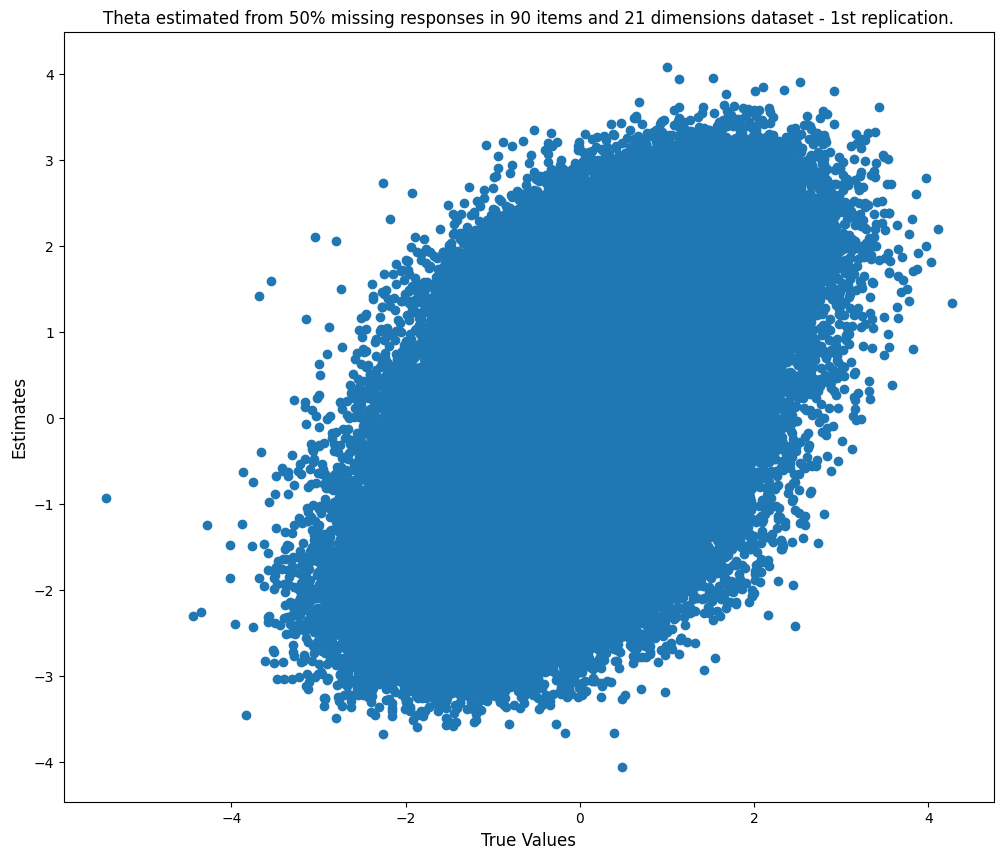

In [31]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=theta_results['Rep1'])
#plt.colorbar()
plt.xlabel('True Values', fontdict={'size': 12})
plt.ylabel('Estimates', fontdict={'size': 12})
plt.title('Theta estimated from 50% missing responses in 90 items and 21 dimensions dataset - 1st replication.')
plt.show()

In [ ]:
theta_results.to_csv('output_data/50_missing/theta/theta_results.csv', sep=';', header=True, index=False)

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=thetas['Rep1'])
#plt.colorbar()
plt.xlabel("True Values", fontdict={'size': 12})
plt.ylabel("Estimates", fontdict={'size': 12})
plt.title("Thetas Estimated for 50% Misssing Responses - 1st Replication")
plt.show()

In [ ]:
theta_df = pd.DataFrame()
theta_df['Estimate'] = thetas['Rep1']
theta_df['Dim'] = ""
theta_df['Dim'][:8000] = 1
theta_df['Dim'][8000:16000] = 2
theta_df['Dim'][16000:] = 3


In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=theta_df['Estimate'], c=theta_df['Dim'], cmap=plt.cm.Set1)
#plt.colorbar()
plt.xlabel("True Values", fontdict={'size': 12})
plt.ylabel("Estimates", fontdict={'size': 12})
plt.title("Difficulties Estimated for 50% Misssing Responses  - 1st Replication")
plt.show()

In [ ]:
print('1st dimension corr: %.4f' % theta_results['theta_values'][:8000].corr(theta_df['Estimate'][:8000]))
print('2nd dimension corr: %.4f' % theta_results['theta_values'][8000:16000].corr(theta_df['Estimate'][8000:16000]))
print('3rd dimension corr: %.4f' % theta_results['theta_values'][16000:].corr(theta_df['Estimate'][16000:]))

## Confusion Matrix

In [ ]:
def matrix_metrix(real_values,pred_values):
   CM = confusion_matrix(real_values,pred_values)
   TN = CM[0][0]
   FN = CM[1][0] 
   TP = CM[1][1]
   FP = CM[0][1]
   Population = TN+FN+TP+FP
   Accuracy   = round( (TP+TN) / Population,4)
   Precision  = round( TP / (TP+FP),4 )
   NPV        = round( TN / (TN+FN),4 )
   FDR        = round( FP / (TP+FP),4 )
   FOR        = round( FN / (TN+FN),4 ) 
   Recall     = round( TP / (TP+FN),4 )
   FPR        = round( FP / (TN+FP),4 )
   FNR        = round( FN / (TP+FN),4 )
   TNR        = round( TN / (TN+FP),4 ) 

   return {'CM': CM, 
           'TN': TN,
           'FN': FN,
           'TP': TP,
           'FP': FP,
           'Population': Population,
           'Accuracy': Accuracy,
           'Precision': Precision,
           'NPV': NPV,
           'FDR': FDR,
           'FOR': FOR,
           'Recall': Recall,
           'FPR': FPR,
           'FNR': FNR,
           'TNR': TNR
           }

In [ ]:
print(confusion_matrix(np.array(originals[0]).flatten(), binary_preds['Rep1']))
skplt.metrics.plot_confusion_matrix(np.array(originals[0]).flatten(), binary_preds['Rep1'],figsize=(8,8))

In [ ]:
res = matrix_metrix(np.array(originals[0]).flatten(), binary_preds['Rep1'])

df = pd.DataFrame({'Metric': res.keys(), 'Value': res.values()})

print(df)

In [ ]:
fpr, tpr, thresholds = roc_curve(np.array(originals[0]).flatten(), preds['Rep1'])
auc = roc_auc_score(np.array(originals[0]).flatten(), preds['Rep1'])
print('AUC: %.3f' % auc)

plt.plot(fpr, tpr, linestyle='--', label='Roc curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(np.array(originals[0]).flatten(), preds['Rep1'])

plt.plot(recall, precision, linestyle='--', label='Precision versus Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Charts

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values, y=thetas[0]['Thetas Estimation'])
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

In [ ]:
print(b_values.shape)
print(negative_diff.shape)

In [ ]:


fig_a = go.Figure()
fig_a.add_trace(go.Scatter(y=discr_hat, mode='lines', name='Python'))
fig_a.add_trace(go.Scatter(y=a_values.iloc[:,0], mode='lines', name='a Real'))
fig_a.update_layout( title="Discrimation")
fig_a.show()

fig_b = go.Figure()
fig_b.add_trace(go.Scatter(y=negative_diff.iloc[:,0], mode='lines', name='Python'))
fig_b.add_trace(go.Scatter(y=b_values.iloc[:,0], mode='lines', name='b Real'))
fig_b.update_layout(title="Difficulty")
fig_b.show()

fig_theta = go.Figure()
#fig_theta.add_trace(go.Scatter(y=theta_rep_gui['Thetas Estimation'], mode='lines', name='Python'))
fig_theta.add_trace(go.Scatter(y=theta_values.iloc[:,0], mode='lines', name='Real'))
fig_theta.update_layout( title="Theta Real")
fig_theta.show()

fig_t = go.Figure()
fig_t.add_trace(go.Scatter(y=theta_rep_gui['Thetas Estimation'], line=dict(color='green',), mode='lines', name='Python'))
#fig_t.add_trace(go.Scatter(y=theta_rep['Thetas_est'], line=dict(color='green',),mode='lines', name='R'))
fig_t.update_layout( title="Theta Hat Python")
fig_t.show()



In [ ]:
theta_values = theta_values.values.reshape((21, 10000)).transpose()

In [ ]:
print(theta_hat.shape)
print(theta_values[:N, :].flatten().shape)

In [ ]:
print(len(discr))

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=theta_values[:N, :].flatten(), y=thetas_hat)
#plt.colorbar()
plt.xlabel("True Values of Theta")
plt.ylabel("Estimates")
plt.show()

In [ ]:
len(discr_hat)

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=a_values, y=discr_hat)
#plt.colorbar()
plt.xlabel("True Values of a_values")
plt.ylabel("Estimates")
plt.show()


In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x=b_values.values.flatten(), y=negative_diff)
#plt.colorbar()
plt.xlabel("True Values of b_values")
plt.ylabel("Estimates")
plt.show()